In [ ]:
%cd '/content/drive/MyDrive/[EURON] 파이썬 머신러닝 완벽 가이드'

/content/drive/MyDrive/[EURON] 파이썬 머신러닝 완벽 가이드


### 09 회귀 실습 - 자전거 대여 수요 예측

#### 데이터 클렌징 및 가공과 데이터 시각화

In [ ]:
# 데이터셋 로드
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

bike = pd.read_csv('data/bike_train.csv')
print(bike.shape)
bike.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
# 데이터 타입 확인
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [ ]:
# 'datetime' 가공 필요
# 문자열을 datetime 타입으로 변환 후 년, 월, 일 시간 추출
bike['datetime'] = bike['datetime'].apply(pd.to_datetime)

bike['year'] = bike.datetime.apply(lambda x : x.year)
bike['month'] = bike.datetime.apply(lambda x : x.month)
bike['day'] = bike.datetime.apply(lambda x : x.day)
bike['hour'] = bike.datetime.apply(lambda x : x.hour)
bike.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [ ]:
# datetime 칼럼 삭제
# casual + registered = count 이므로 casual과 registered 삭제
drop_columns = ['datetime','casual','registered']
bike.drop(drop_columns, axis=1, inplace=True)

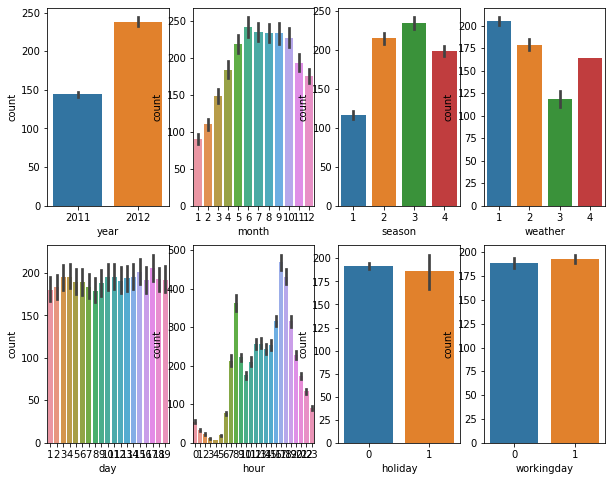

In [ ]:
# 주요 칼럼별 count 분포 시각화
fig, axs = plt.subplots(figsize=(10,8), ncols=4, nrows=2)
cat_features = ['year','month','season','weather','day','hour','holiday','workingday']

for i, feature in enumerate(cat_features):
  row = int(i/4)
  col = i%4
  sns.barplot(x=feature, y='count', data=bike, ax=axs[row][col])

In [ ]:
# RMSLE, MSE, RMSE 평가 함수 생성
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log값 변환 -> log1p
def rmsle(y,pred):
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred) ** 2
  rmsle = np.sqrt(np.mean(squared_error))
  return rmsle

# RMSE 계산
def rmse(y, pred):
  return np.sqrt(mean_squared_error(y,pred))

# 모두 계산
def evaluate_regr(y,pred):
  rmsle_val = rmsle(y,pred)
  rmse_val = rmse(y,pred)
  mae_val = mean_absolute_error(y,pred)
  print('RMSLE : {0:.3f} / RMSE : {1:.3f} / MAE : {2:.3f}'.format(rmsle_val, rmse_val, mae_val))

#### 로그 변환, 피처 인코딩, 모델 학습/예측 평가

In [ ]:
# LinearRegression 회귀 예측 -> 큰 예측 오류
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike['count']
X_features = bike.drop(['count'],axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)
evaluate_regr(y_test, pred)

RMSLE : 1.165 / RMSE : 140.900 / MAE : 105.924


In [ ]:
# 실제값과 예측값이 어느 정도 차이가 나는지 확인
def get_top_error_data(y_test, pred, n_tops = 5):
  result = pd.DataFrame(y_test.values, columns=['real_count'])
  result['predicted_count'] = np.round(pred)
  result['diff'] = np.abs(result['real_count']-result['predicted_count'])

  print(result.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


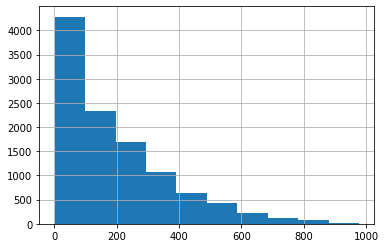

In [ ]:
# 큰 예측 오류 발생
# 1. Target 값의 분포가 왜곡된 형태를 이루고 있는지 확인 -> 정규분포 형태인지 확인
y_target.hist()

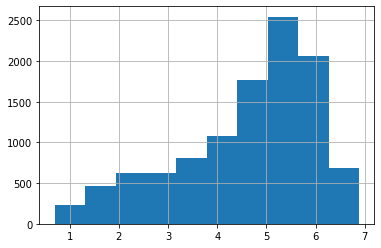

In [ ]:
# 0~200 사이에 왜곡 존재 -> 로그 변환
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [ ]:
# 재학습, 평가 수행
y_target_log = np.log1p(y_target)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터셋의 target 값이 로그 변환 되었으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)
evaluate_regr(y_test_exp, pred_exp)

# RMSLE 오류 감소 but RMSE 오류는 오히려 증가

RMSLE : 1.017 / RMSE : 162.594 / MAE : 109.286


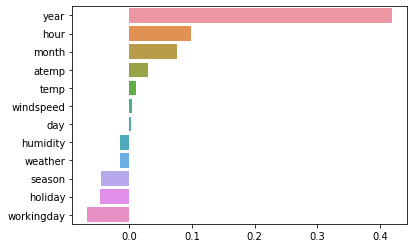

In [ ]:
# 2. 개별 피처에 인코딩 적용
# 각 피처 회귀 계숫값 시각화
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [ ]:
# year, hour, month 등은 카테고리형 피처 -> 원-핫 인코딩 적용
X_features_ohe = pd.get_dummies(X_features, columns=['year','month','day','hour','holiday','workingday','season','weather'])

In [ ]:
# linearRegression, Ridge :asso를 학습해 성능 평가 수치를 반환하는 함수 생성
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)

  if is_expm1:
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)
  print('###', model.__class__.__name__,'###')
  evaluate_regr(y_test, pred)

# 모델별 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
  get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE : 0.590 / RMSE : 97.688 / MAE : 63.382
### Ridge ###
RMSLE : 0.590 / RMSE : 98.529 / MAE : 63.893
### Lasso ###
RMSLE : 0.635 / RMSE : 113.219 / MAE : 72.803


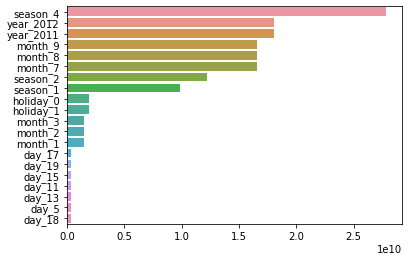

In [ ]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [ ]:
# 회귀 트리로 예측 수행
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg,gbm_reg,xgb_reg,lgbm_reg]:
  # XGBoost의 경우 DataFrame이 입력될 경우 버전에 따라 오류 발생 가능 -> ndarray로 변환
  get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)

### RandomForestRegressor ###
RMSLE : 0.355 / RMSE : 50.214 / MAE : 31.120
### GradientBoostingRegressor ###
RMSLE : 0.330 / RMSE : 53.342 / MAE : 32.746
[08:02:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### XGBRegressor ###
RMSLE : 0.345 / RMSE : 58.245 / MAE : 35.768
### LGBMRegressor ###
RMSLE : 0.319 / RMSE : 47.215 / MAE : 29.029


### 10 회귀 실습 - 캐글 주택 가격 : 고급 회귀 기법

#### 데이터 사전 처리

In [ ]:
# 데이터 로드, 원본 데이터 저장
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_org = pd.read_csv('data/house_price.csv')
house = house_org.copy()
house.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [ ]:
print('데이터셋의 shape : ',house.shape)
print('\n전체 피처의 type\n', house.dtypes.value_counts())
isnull_series = house.isnull().sum()
print('\nNull 칼럼과 그 건수 : \n', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터셋의 shape :  (1460, 81)

전체 피처의 type
 object     43
int64      35
float64     3
dtype: int64

Null 칼럼과 그 건수 : 
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


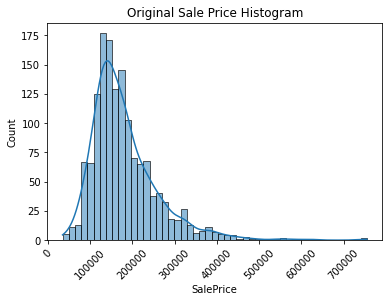

In [ ]:
# 타깃값 분포 확인 -> 정규분포에서 벗어난 형태
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=45)
sns.histplot(house['SalePrice'],kde=True)
plt.show()

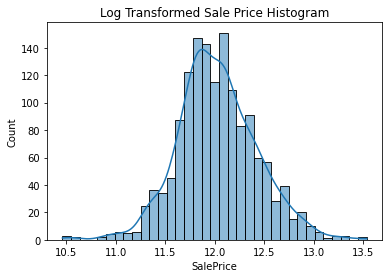

In [ ]:
# 로그 변환
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

In [ ]:
# SalePrice 로그변환
original_SalePrice = house['SalePrice']
house['SalePrice'] = np.log1p(house['SalePrice'])

# Null이 너무 많은 칼럼과 불필요한 칼럼 삭제
house.drop(['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis=1, inplace=True)

# 드롭하지 않는 숫자형 Null 칼럼은 평균값으로 대체
house.fillna(house.mean(), inplace=True)

# Null 값이 있는 피처명과 타입 추출
null_column_count = house.isnull().sum()[house.isnull().sum()>0]
print('## Null 피처의 Type : \n', house.dtypes[null_column_count.index])

## Null 피처의 Type : 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [ ]:
# 원핫 인코딩으로 문자형 피처 변환 
# 원핫 인코딩은 자동으로 널 값을 0으로 대체해 줌
print('get_dummies() 수행 전 데이터 Shape : ',house.shape)
house_ohe = pd.get_dummies(house)
print('get_dummies() 수행 후 데이터 Shape : ',house_ohe.shape)

null_column_count = house_ohe.isnull().sum()[house_ohe.isnull().sum()>0]
print('## Null 피처의 Type : \n', house_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape :  (1460, 75)
get_dummies() 수행 후 데이터 Shape :  (1460, 271)
## Null 피처의 Type : 
 Series([], dtype: object)


#### 선형 회귀 모델 학습/예측/평가

In [ ]:
def get_rmse(model):
  pred = model.predict(X_test)
  mse = mean_squared_error(y_test,pred)
  rmse = np.sqrt(mse)
  print(model.__class__.__name__,' 로그 변환된 RMSE : ', np.round(rmse,3))
  return rmse

def get_rmses(models):
  rmses=[]
  for model in models:
    rmse = get_rmse(model)
    rmses.append(rmse)
  return rmses

In [ ]:
# 선형 회귀 모델 학습/예측/평가
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_ohe['SalePrice']
X_features = house_ohe.drop('SalePrice',axis=1,inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train,y_train)

models = [lr_reg, ridge_reg,lasso_reg]
get_rmses(models)

LinearRegression  로그 변환된 RMSE :  0.132
Ridge  로그 변환된 RMSE :  0.128
Lasso  로그 변환된 RMSE :  0.176


[0.13189576579153628, 0.12750846334052995, 0.17628250556471403]

In [ ]:
# 피처별 회귀 계수 시각화
def get_top_bottom_coef(model, n=10):
  coef = pd.Series(model.coef_,index=X_features.columns)

  coef_high = coef.sort_values(ascending=False).head(n)
  coef_low = coef.sort_values(ascending=False).tail(n)
  return coef_high, coef_low

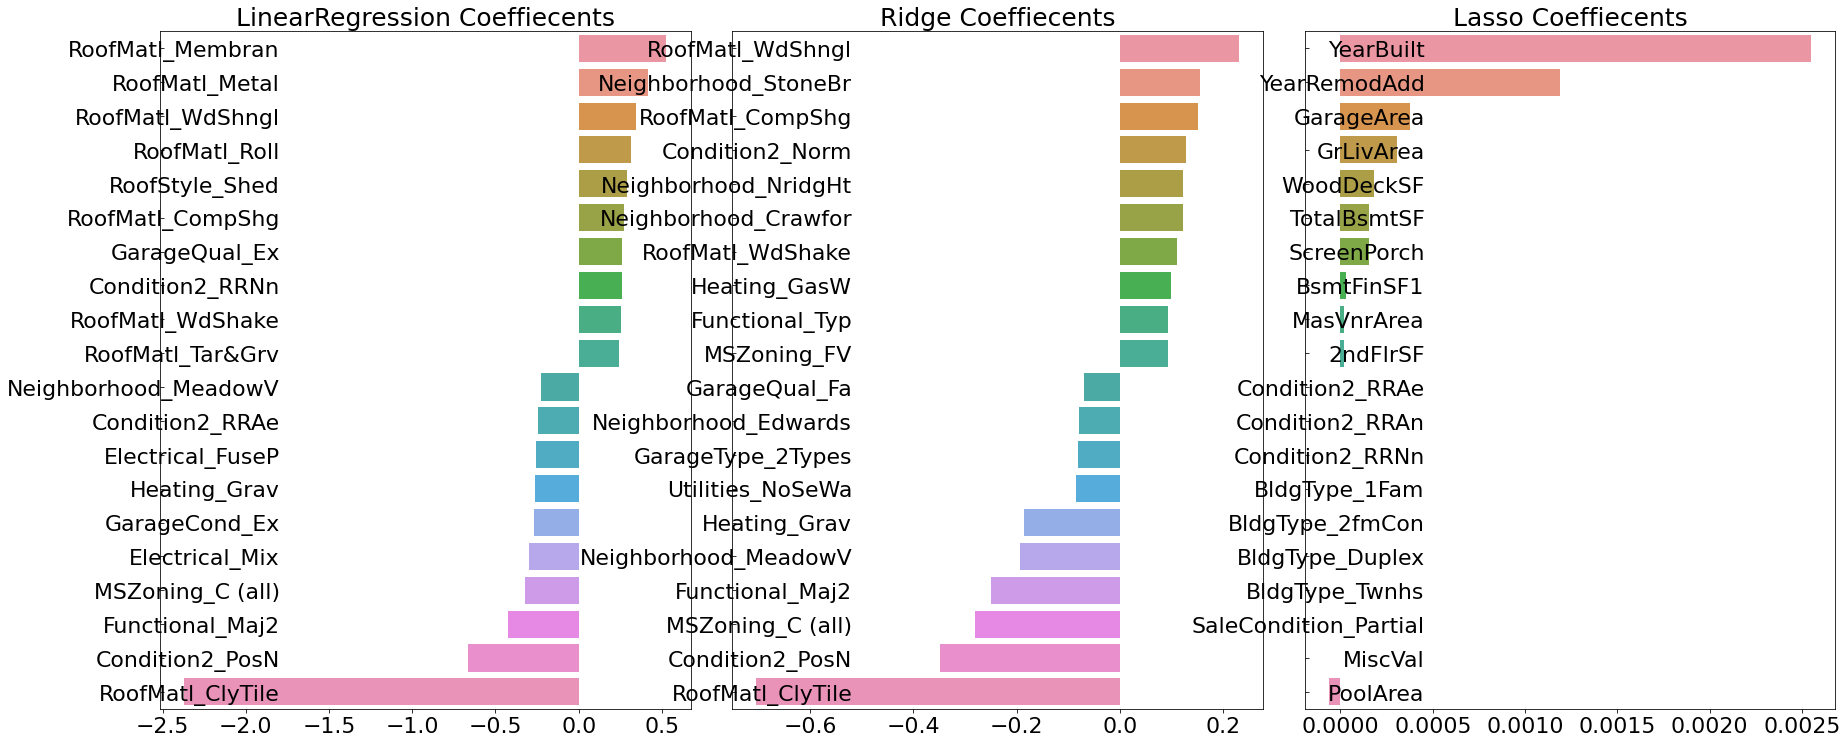

In [ ]:
# 시각화 함수
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.    
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [ ]:
# Lasso : 전체적으로 회귀 계수 값이 매우 작음, 특히 YearBuilt가 가장 큼
# 데이터 분할에 문제가 있는지 확인하기 위해 교차 검증 폴드 세트로 분할하여 평균 RMSE 측정
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
  for model in models:
    rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring="neg_mean_squared_error",cv=5))
    rmse_avg = np.mean(rmse_list)
    print('\n{0} CV RMSE 값 리스트 : {1}'.format(model.__class__.__name__, np.round(rmse_list,3)))
    print('{0} CV 평균 RMSE값 : {1}'.format(model.__class__.__name__, np.round(rmse_avg,3)))

models = [ridge_reg, lasso_reg]
get_avg_rmse_cv(models)

# 여전히 라쏘 성능 떨어짐


Ridge CV RMSE 값 리스트 : [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE값 : 0.144

Lasso CV RMSE 값 리스트 : [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE값 : 0.198


In [ ]:
# alpha 하이퍼 파라미터 최적 값 도출
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
  grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
  grid_model.fit(X_features, y_target)
  rmse = np.sqrt(-1 * grid_model.best_score_)
  print('{0} 5 CV 시 최적 평균 RMSE 값 : {1} / 최적 alpha : {2}'.format(model.__class__.__name__, np.round(rmse,4), grid_model.best_params_))

ridge_params = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha' : [0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1418 / 최적 alpha : {'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.142 / 최적 alpha : {'alpha': 0.001}


LinearRegression  로그 변환된 RMSE :  0.132
Ridge  로그 변환된 RMSE :  0.124
Lasso  로그 변환된 RMSE :  0.12


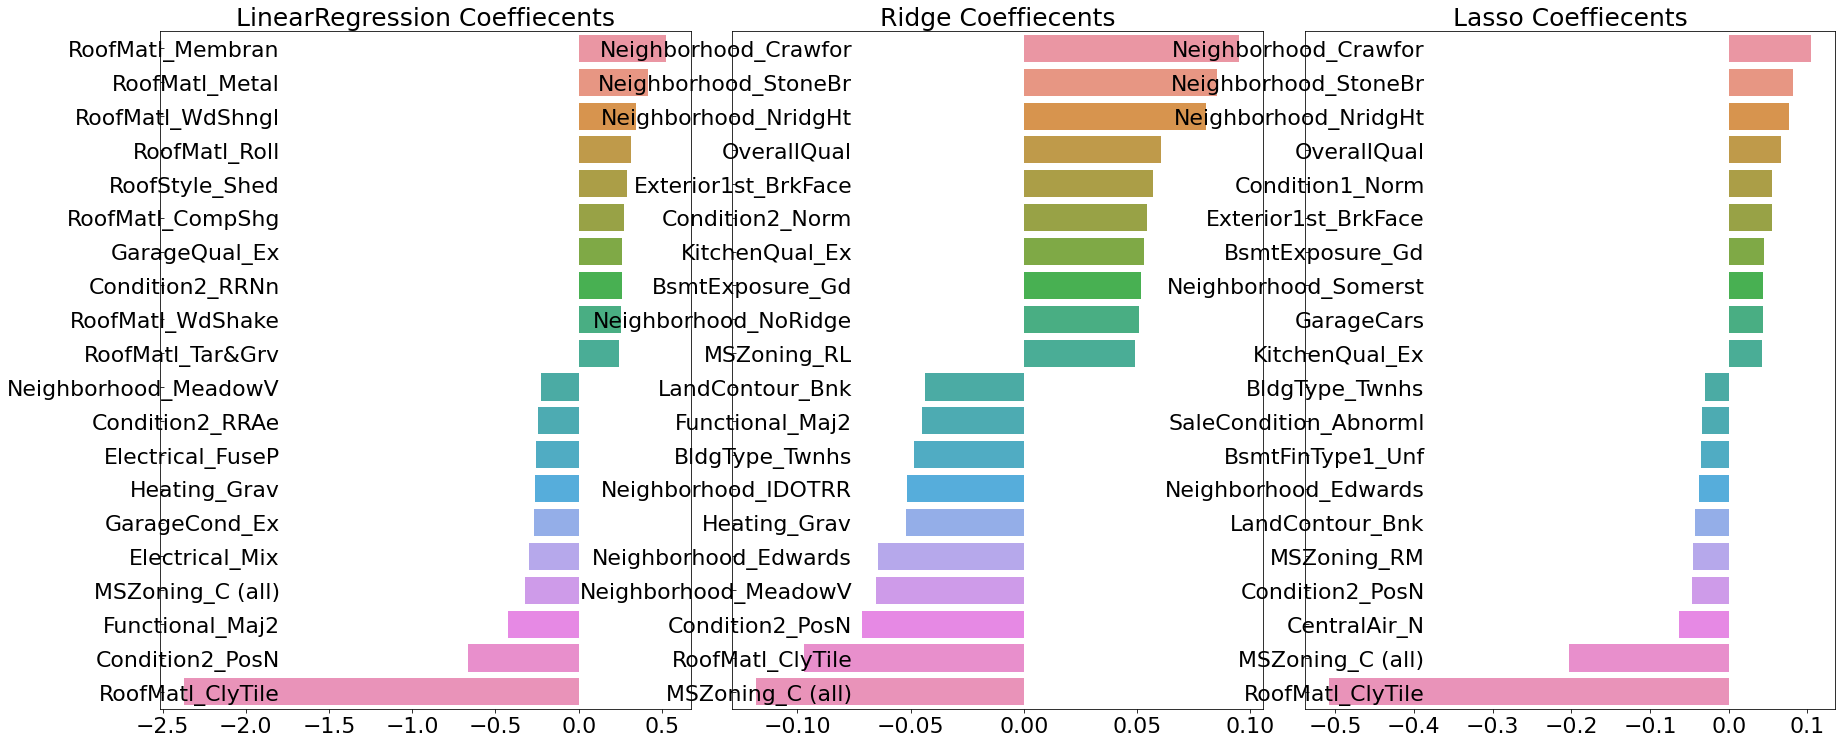

In [ ]:
# 최적화 alpha 값으로 예측/평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [ ]:
# 왜곡 정도 확인 - skew()
# 원-핫 인코딩된 카테고리 숫자형 피처 제외
from scipy.stats import skew

features_index = house.dtypes[house.dtypes != 'object'].index
skew_features = house[features_index].apply(lambda x : skew(x))
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [ ]:
# 왜곡 정도가 높은 피처 로그 변환
house[skew_features_top.index] = np.log1p(house[skew_features_top.index])

In [ ]:
# 다시 원-핫 인코딩 적용
house_ohe = pd.get_dummies(house)
y_target = house_ohe['SalePrice']
X_features = house_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha' : [0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1275 / 최적 alpha : {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1252 / 최적 alpha : {'alpha': 0.001}


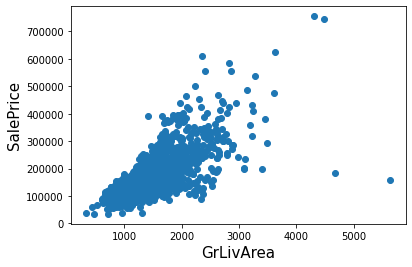

In [ ]:
plt.scatter(x=house_org['GrLivArea'], y=house_org['SalePrice'])
plt.ylabel('SalePrice',fontsize=15)
plt.xlabel('GrLivArea', fontsize = 15)
plt.show()

In [ ]:
# 로그변환을 반영한 조건 생성
cond1 = house_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_ohe[cond1 & cond2].index

print('이상치 레코드 index : ',outlier_index.values)
print('이상치 삭제 전 house_ohe shape : ', house_ohe.shape)

house_ohe.drop(outlier_index, axis=0, inplace=True)
print("이상치 삭제 후 house_ohe shape : ", house_ohe.shape)

이상치 레코드 index :  [ 523 1298]
이상치 삭제 전 house_ohe shape :  (1460, 271)
이상치 삭제 후 house_ohe shape :  (1458, 271)


In [ ]:
# 릿지, 라쏘 최적화 수행
y_target = house_ohe['SalePrice']
X_features = house_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1125 / 최적 alpha : {'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1122 / 최적 alpha : {'alpha': 0.001}


LinearRegression  로그 변환된 RMSE :  0.129
Ridge  로그 변환된 RMSE :  0.103
Lasso  로그 변환된 RMSE :  0.1


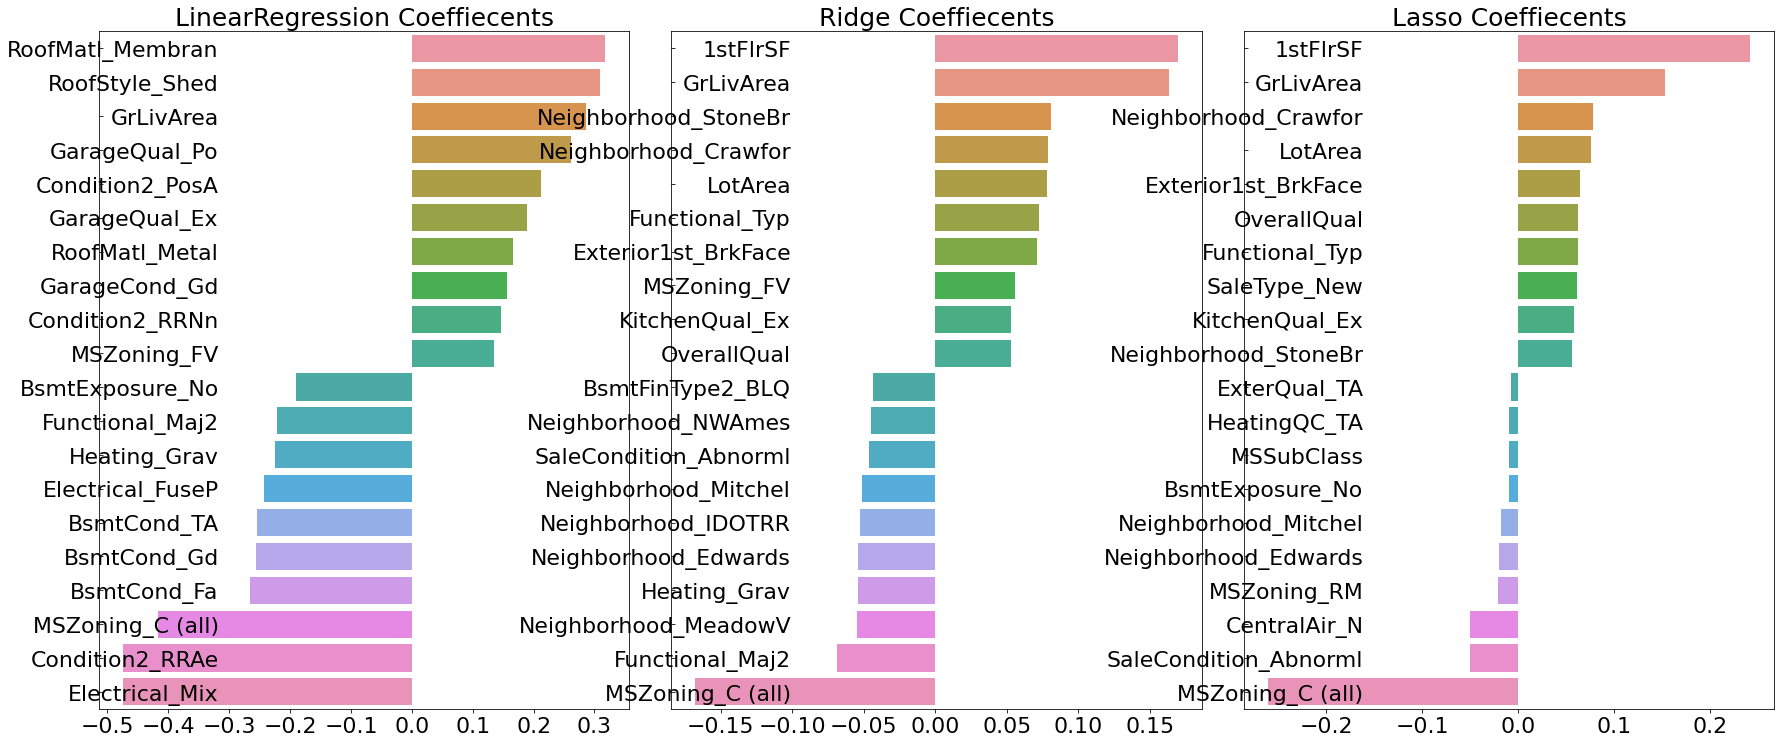

In [ ]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

#### 회귀 트리 모델 학습/예측/평가

In [ ]:
from xgboost import XGBRegressor
xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

[10:27:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:27:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:27:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:27:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:27:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor 5 CV 시 최적 평균 RMSE 값 : 0.115 / 최적 alpha : {'n_estimators': 1000}


In [ ]:
from lightgbm import LGBMRegressor
lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators = 1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값 : 0.1161 / 최적 alpha : {'n_estimators': 1000}


#### 회귀 모델의 예측 결과 혼합을 통한 최종 예측

In [ ]:
def get_rmse_pred(preds):
  for key in preds.keys():
    pred_value = preds[key]
    mse = mean_squared_error(y_test, pred_value)
    rmse = np.sqrt(mse)
    print('{0} 모델의 RMSE : {1}'.format(key,rmse))

ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

pred = 0.4 * ridge_pred + 0.6 * lasso_pred   # 성능이 조금 더 좋은 쪽에 가중치를 약간 둠
preds = {'최종 혼합' : pred, 'Ridge':ridge_pred, 'Lasso':lasso_pred}
get_rmse_pred(preds)

최종 혼합 모델의 RMSE : 0.10007930884470513
Ridge 모델의 RMSE : 0.10345177546603244
Lasso 모델의 RMSE : 0.10024170460890035


In [ ]:
# XGB와 LGBM 혼합
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate = 0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate = 0.05, num_leaves = 4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)

xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred   # 성능이 조금 더 좋은 쪽에 가중치를 약간 둠
preds = {'최종 혼합' : pred, 'XGBM':xgb_pred, 'LGBM':lgbm_pred}
get_rmse_pred(preds)

[10:35:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
최종 혼합 모델의 RMSE : 0.09897715854093486
XGBM 모델의 RMSE : 0.10075115846547565
LGBM 모델의 RMSE : 0.1015065721553885


#### 스태킹 앙상블 모델을 통한 회귀 예측

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [ ]:
# get_stacking_base_datasets( )은 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환. 
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
[10:39:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  1  시작 
[10:39:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  2  시작 
[10:39:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  3  시작 
[10:39:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  4  시작 
[10:39:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  

In [ ]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.  
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, 
                                      xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, 
                                     xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용. 
meta_model_lasso = Lasso(alpha=0.0005)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)